## Savita Medlang
### INF 552
### Assigment 3

In [90]:
import glob
import pandas as pd

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


bending1_files = glob.glob('../data/AReM/bending1/*')
bending2_files = glob.glob('../data/AReM/bending2/*')
cycling_files = glob.glob('../data/AReM/cycling/*')
lying_files = glob.glob('../data/AReM/lying/*')
sitting_files = glob.glob('../data/AReM/sitting/*')
standing_files = glob.glob('../data/AReM/standing/*')
walking_files = glob.glob('../data/AReM/walking/*')

### (b) Split data

In [2]:
train_files = []
test_files = []
for file in bending1_files + bending2_files:
    if 'dataset1' in file or 'dataset2' in file:
        test_files.append(file)
    else:
        train_files.append(file)
        
for file in cycling_files + lying_files + sitting_files + standing_files + walking_files:
    if 'dataset1' in file or 'dataset2' in file or 'dataset3' in file:
        test_files.append(file)
    else:
        train_files.append(file)

### (c) i Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)
Mean, Standard Deviation, Skewness, Kurtosis and Higher order moments, Max and min of the input variables
Cross correlation between each predictor 
TODO: more?? 

### (c) ii 

In [3]:

all_files = bending1_files+bending2_files+cycling_files+lying_files+sitting_files+standing_files+walking_files
##1 file = 1 instance
def td_features(train_file_arr, bendingFlag=False):
    six_columns = ['min1', 'max1','mean1','median1','std1','1stQ1','3rdQ1','min2', 'max2','mean2','median2','std2','1stQ2','3rdQ2','min3', 'max3','mean3','median3','std3','1stQ3','3rdQ3','min4', 'max4','mean4','median4','std4','1stQ4','3rdQ4','min5', 'max5','mean5','median5','std5','1stQ5','3rdQ5','min6', 'max6','mean6','median6','std6','1stQ6','3rdQ6']
    if bendingFlag:
        six_columns.append('bending')
    train_td_features = pd.DataFrame(columns=six_columns)
    for file in train_file_arr:
        df = pd.read_csv(file)
        new_instance={}
        i=1
        for column in df.columns:
            if column != 'Time' and column != 'time':
                new_instance['min'+str(i)] = df[column].min()
                new_instance['max'+str(i)] = df[column].max()
                new_instance['mean'+str(i)] = df[column].mean()
                new_instance['median'+str(i)] = df[column].median()
                new_instance['std'+str(i)] = df[column].std()
                new_instance['1stQ'+str(i)] = df[column].quantile(0.25)
                new_instance['3rdQ'+str(i)] = df[column].quantile(0.75)
                i = i+1
        if bendingFlag:
            new_instance['bending'] = ('bending' in file)
        train_td_features = train_td_features.append(new_instance,ignore_index=True)

    # print(instance1)
    # td_features.append(instance1)
    return train_td_features

td_features_table= td_features(all_files)
td_features_table

min1   max1      mean1  median1      std1    1stQ1    3rdQ1  min2   max2  \
0   36.25  48.00  43.969125   44.500  1.618364  43.3100  44.6700   0.0   1.50   
1   37.00  48.00  43.454958   43.250  1.386098  42.5000  45.0000   0.0   1.58   
2   33.00  47.75  42.179813   43.500  3.670666  39.1500  45.0000   0.0   3.00   
3   33.00  45.75  41.678063   41.750  2.243490  41.3300  42.7500   0.0   2.83   
4   37.25  45.00  40.624792   40.500  1.476967  39.2500  42.0000   0.0   1.30   
5   38.00  45.67  42.812812   42.500  1.435550  42.0000  43.6700   0.0   1.22   
6   35.00  47.40  43.954500   44.330  1.558835  43.0000  45.0000   0.0   1.70   
7   25.00  47.50  31.058250   29.710  4.829794  27.5000  31.8125   0.0   6.38   
8   27.50  33.00  29.881938   30.000  1.153837  29.0000  30.2700   0.0   1.00   
9   19.00  45.50  30.938104   29.000  7.684146  26.7500  38.0000   0.0   6.40   
10  12.75  51.00  24.562958   24.250  3.737514  23.1875  26.5000   0.0   6.87   
11   0.00  42.75  27.464604   28.000  3.583582  25.5000  30.0000   0.0   7.76   
12  21.00  50.00  32.586208   33.000  6.238143  26.1875  34.5000   0.0   9.90   
13  26.75  44.75  36.863375   36.330  3.555787  34.5000  39.7500   0.0  11.68   
14  25.33  45.00  37.114312   36.250  3.710385  34.5000  40.2500   0.0  10.84   
15  19.00  44.00  36.228396   36.000  3.528617  34.0000  39.0000   0.0  12.28   
16  26.50  44.33  36.687292   36.000  3.529404  34.2500  39.3725   0.0  12.89   
17  24.25  45.00  37.177042   36.250  3.581301  34.5000  40.2500   0.0   8.58   
18  28.75  44.75  37.561188   36.875  3.226507  35.2500  40.2500   0.0   9.91   
19  22.00  44.67  37.058708   36.000  3.710180  34.5000  40.0625   0.0  14.17   
20  27.00  45.00  36.819521   36.000  3.900459  33.7500  40.2500   0.0  10.47   
21  27.00  44.33  36.541667   36.000  4.018922  33.2500  39.8125   0.0  10.43   
22  19.00  43.75  35.879875   36.000  4.614878  33.0000  39.5000   0.0  11.20   
23  18.50  44.25  35.752354   36.000  4.614802  33.0000  39.3300   0.0  12.60   
24  24.25  45.00  37.177042   36.250  3.581301  34.5000  40.2500   0.0   8.58   
25  23.33  43.50  36.244083   36.750  3.822016  33.4575  39.2500   0.0   9.71   
26  26.25  44.25  36.957458   36.290  3.434863  34.5000  40.2500   0.0   8.64   
27  27.75  44.67  37.144833   36.330  3.758904  34.0000  40.5000   0.0  10.76   
28  39.00  40.00  39.433792   39.500  0.208558  39.3300  39.5000   0.0   1.00   
29   0.00  40.67  39.506187   39.500  1.817498  39.5000  39.6700   0.0   1.00   
..    ...    ...        ...      ...       ...      ...      ...   ...    ...   
58  35.50  48.00  46.224937   46.000  1.748315  45.2500  48.0000   0.0   4.50   
59  34.50  47.75  44.471146   45.000  1.772553  45.0000  45.2500   0.0   2.18   
60  30.00  46.67  42.648521   42.750  2.395338  41.5000  45.0000   0.0   2.95   
61  36.00  47.50  43.720021   45.000  2.384105  43.0000  45.0000   0.0   1.92   
62  33.33  48.00  44.334729   45.000  2.476940  42.2500  46.5000   0.0   3.90   
63  35.50  46.25  43.174938   43.670  1.989052  42.5000  44.5000   0.0   2.12   
64  32.75  47.00  42.760563   44.500  3.398919  41.3300  45.3725   0.0   3.34   
65  36.00  45.80  42.419917   42.670  2.520129  41.3300  44.6175   0.0   2.12   
66  37.00  48.25  42.516958   42.500  2.195751  41.0000  44.5000   0.0   2.12   
67  36.00  47.33  42.674583   43.670  2.384170  40.0000  44.7500   0.0   2.17   
68  36.25  45.50  42.959354   42.670  1.500878  42.0000  44.3300   0.0   2.60   
69  36.00  47.33  44.441187   45.000  2.417797  44.6275  45.7500   0.0   4.50   
70  36.25  45.75  43.187521   44.750  2.491162  39.7500  45.0000   0.0   2.83   
71  29.75  48.00  46.932208   47.500  1.832665  47.2375  47.7500   0.0   4.60   
72  36.33  47.67  45.399625   45.500  1.328121  45.0000  46.3300   0.0   1.66   
73  18.33  47.67  34.333042   34.750  4.948770  31.2500  38.0000   0.0  12.48   
74  21.50  51.00  34.935813   35.500  4.645944  32.0000  38.0625   0.0  12.21   
75  18.00  46.00  35.193333   36.000

### (c) iii standard deviation of time features

In [4]:
instance_std = []
for column in td_features_table.columns:
    instance_std.append(td_features_table[column].std())

keys = ['min1', 'max1','mean1','median1','std1','1stQ1','3rdQ1','min2', 'max2','mean2','median2','std2','1stQ2','3rdQ2','min3', 'max3','mean3','median3','std3','1stQ3','3rdQ3','min4', 'max4','mean4','median4','std4','1stQ4','3rdQ4','min5', 'max5','mean5','median5','std5','1stQ5','3rdQ5','min6', 'max6','mean6','median6','std6','1stQ6','3rdQ6']
row = {}
for i in range(0, len(keys)):
    row[keys[i]] = [instance_std[i]]
std_df=pd.DataFrame.from_dict(row)
std_df.rename(index={0:'std'}, inplace=True)
std_df

min1      max1     mean1   median1      std1    1stQ1     3rdQ1  \
std  9.569975  4.394362  5.335718  5.440054  1.772153  6.15359  5.138925   

     min2      max2     mean2  ...      std5     1stQ5    3rdQ5      min6  \
std   0.0  5.062729  1.574164  ...  1.024898  6.096465  5.53172  0.045838   

         max6     mean6   median6      std6     1stQ6     3rdQ6  
std  2.518921  1.154812  1.086474  0.517617  0.758584  1.523599  

[1 rows x 42 columns]

### (c) iii std using bootstrapped

In [5]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
# std_df = std_df.to_numpy()
for column in td_features_table.columns:
    print(column + ':    ', bs.bootstrap(td_features_table[column].to_numpy(), stat_func=bs_stats.std, alpha=0.1))


min1:     9.515445066931841    (8.291307728545435, 10.804396484473047)
max1:     4.36932238296287    (3.4853748893951977, 5.41250230043201)
mean1:     5.305314461239687    (4.755081843096856, 5.9260592279185875)
median1:     5.409056425357996    (4.857413603524597, 6.053606833926179)
std1:     1.7620555751491025    (1.5856884984406527, 1.9686891404943612)
1stQ1:     6.118526249454473    (5.622610652548849, 6.683435784361262)
3rdQ1:     5.109642753365408    (4.411985679724689, 5.905103205026011)
min2:     0.0    (0.0, 0.0)
max2:     5.033881679163114    (4.68765116581897, 5.468254908342982)
mean2:     1.565194252074566    (1.4347051239969797, 1.7350228824280265)
median2:     1.4041971241720508    (1.270037402197313, 1.5761380462518566)
std2:     0.8790677991268445    (0.8216919550352493, 0.9595302262872137)
1stQ2:     0.9409936333203218    (0.8523261656130718, 1.058003861458477)
3rdQ2:     2.113156527737114    (1.9414821669910225, 2.346746252717012)
min3:     2.939615984418221    (2.793

### (c) iv.  Select the three most important time-domain features

I selected mean, median, max to be the three most important time-domain features. I calculated the correlation and chose these values.

### (d) Binary Classification Using Logistic Regression

In [6]:
import seaborn as sns
train_td_features_table= td_features(train_files, bendingFlag=True)
train_td_features_table

def pairplot(data):
    sns.pairplot(data, hue="bending")




### scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6

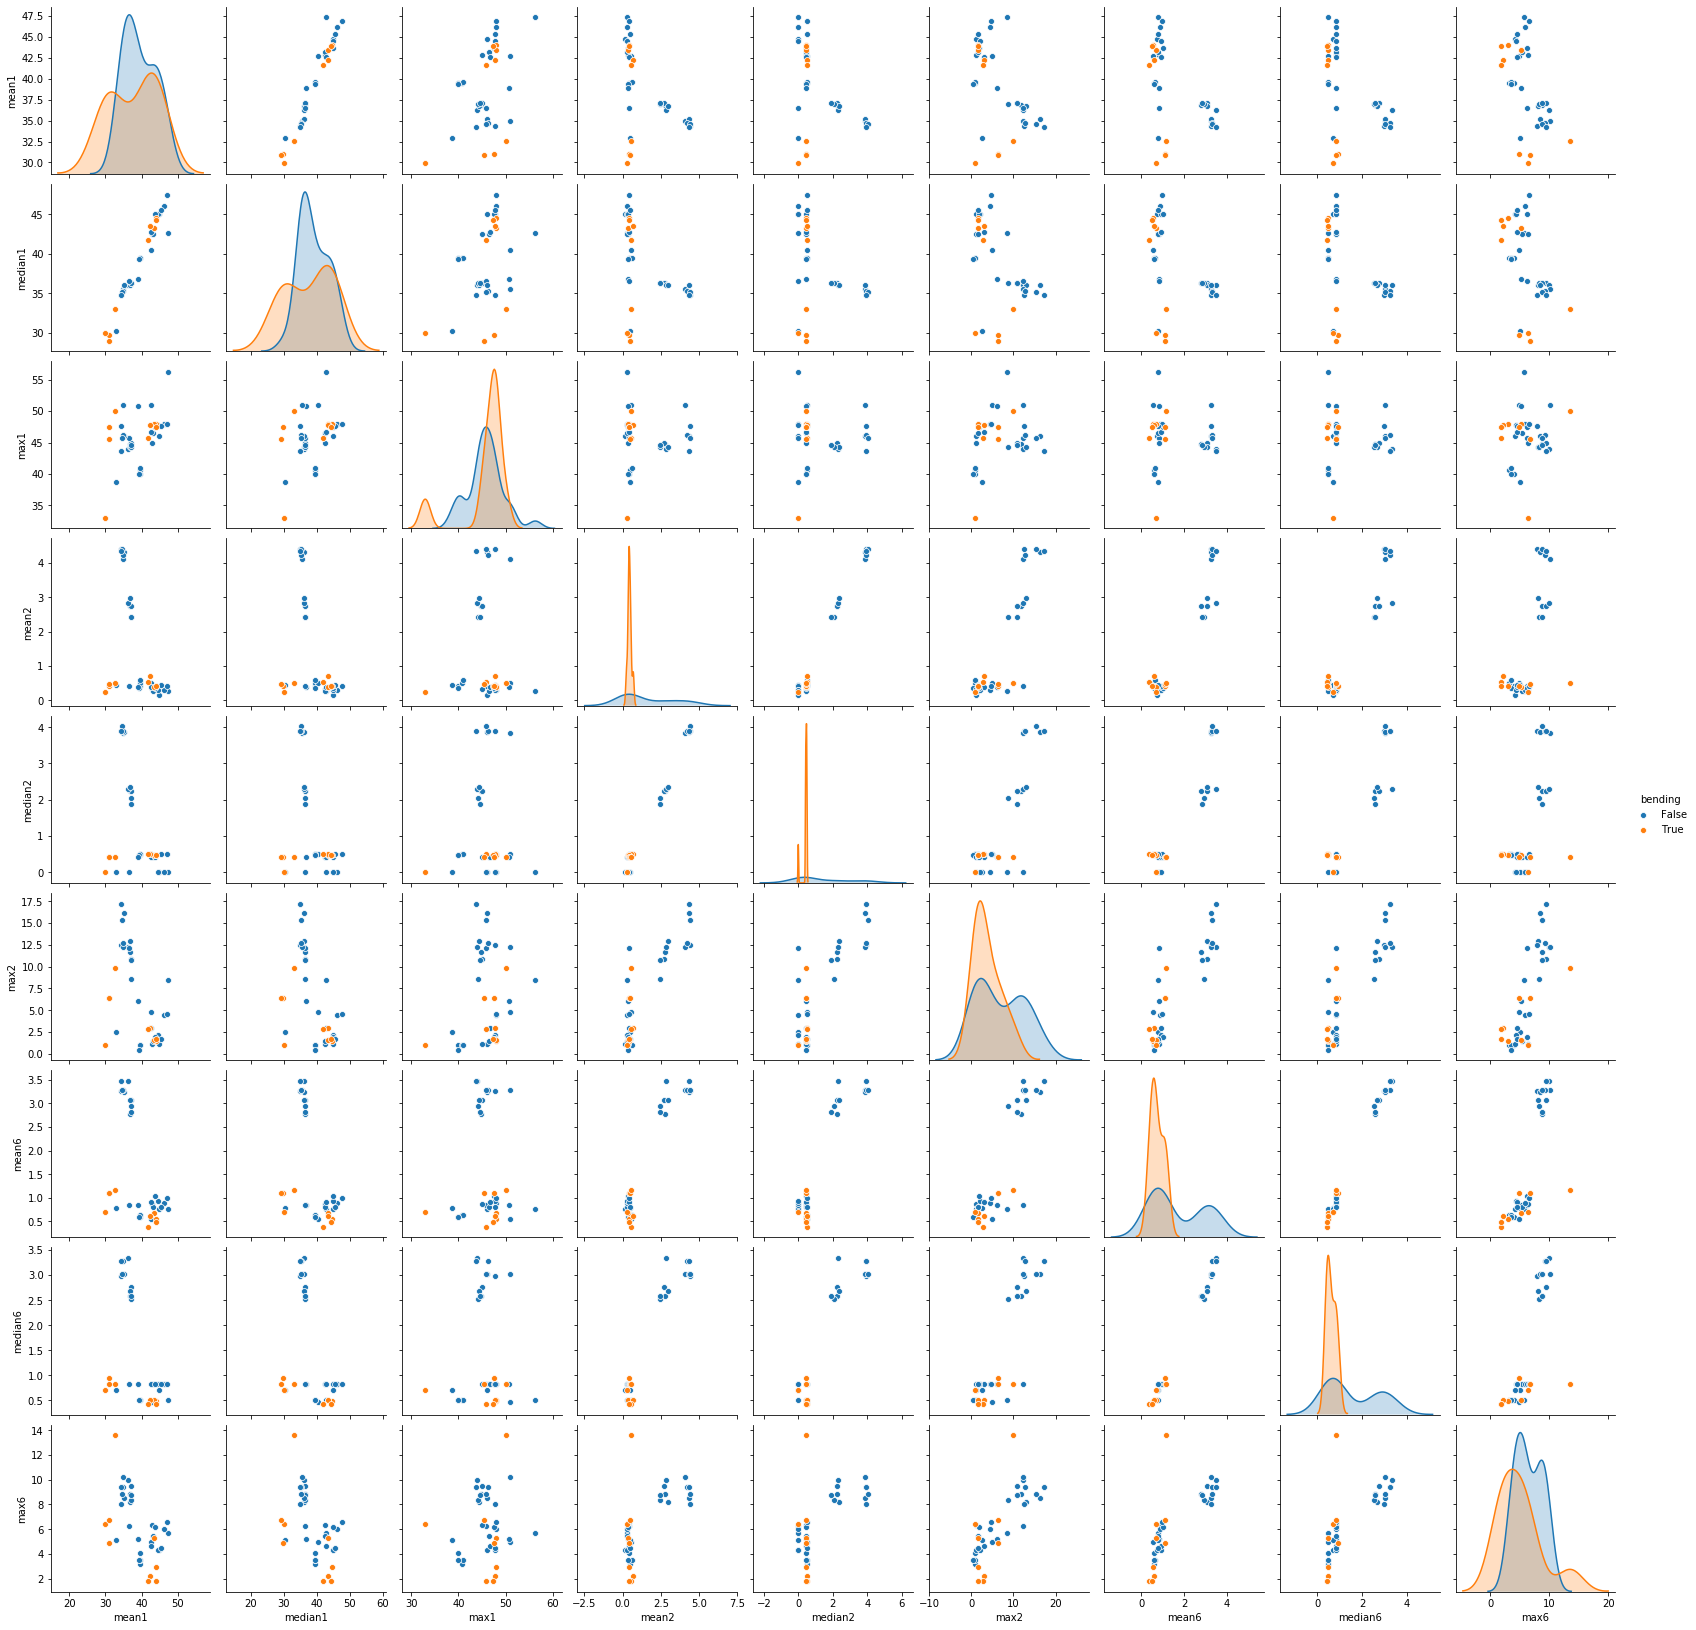

In [7]:
pairplot_data = train_td_features_table[['mean1', 'median1', 'max1', 'mean2','median2', 'max2', 'mean6', 'median6', 'max6', 'bending']]
pairplot(pairplot_data)

In [8]:

# head = train_td_features_table.head(44)
# train_td_tail = train_td_features_table.tail(44)
# columns_tail = train_td_tail.columns
# new_columns = []
# for i in range(0, len(columns_tail)):
#     new_columns.append(columns_tail[i] +"-2")

# train_td_tail.columns = new_columns
# # print(train_td_tail)
# halves = pd.concat([head, train_td_tail], axis=1, sort=False)
# print(halves)
# print(halves['min1'][0:50])
import math
def twelve_features(all_files, bendingFlag=False):
    twelve_columns = ['min1', 'max1','mean1','median1','std1','1stQ1','3rdQ1','min2', 'max2','mean2','median2','std2','1stQ2','3rdQ2','min3', 'max3','mean3','median3','std3','1stQ3','3rdQ3','min4', 'max4','mean4','median4','std4','1stQ4','3rdQ4','min5', 'max5','mean5','median5','std5','1stQ5','3rdQ5','min6', 'max6','mean6','median6','std6','1stQ6','3rdQ6', 'min1-2', 'max1-2','mean1-2','median1-2','std1-2','1stQ1-2','3rdQ1-2','min2-2', 'max2-2','mean2-2','median2-2','std2-2','1stQ2-2','3rdQ2-2','min3-2', 'max3-2','mean3-2','median3-2','std3-2','1stQ3-2','3rdQ3-2','min4-2', 'max4-2','mean4-2','median4-2','std4-2','1stQ4-2','3rdQ4-2','min5-2', 'max5-2','mean5-2','median5-2','std5-2','1stQ5-2','3rdQ5-2','min6-2', 'max6-2','mean6-2','median6-2','std6-2','1stQ6-2','3rdQ6-2']
    if bendingFlag:
        twelve_columns.append('bending')
    td_features = pd.DataFrame(columns=twelve_columns)
    for file in all_files:
        df = pd.read_csv(file)
        new_instance={}
        i=1
        for column in df.columns:
            num_rows = df[column].shape[0]
            half_index = math.floor(num_rows/2)
            if column != 'Time' and column != 'time':
                new_instance['min'+str(i)] = df[column][0:half_index].min()
                new_instance['max'+str(i)] = df[column][0:half_index].max()
                new_instance['mean'+str(i)] = df[column][0:half_index].mean()
                new_instance['median'+str(i)] = df[column][0:half_index].median()
                new_instance['std'+str(i)] = df[column][0:half_index].std()
                new_instance['1stQ'+str(i)] = df[column][0:half_index].quantile(0.25)
                new_instance['3rdQ'+str(i)] = df[column][0:half_index].quantile(0.75)
                new_instance['min'+str(i)+"-2"] = df[column][half_index:num_rows-1].min()
                new_instance['max'+str(i)+"-2"] = df[column][half_index:num_rows-1].max()
                new_instance['mean'+str(i)+"-2"] = df[column][half_index:num_rows-1].mean()
                new_instance['median'+str(i)+"-2"] = df[column][half_index:num_rows-1].median()
                new_instance['std'+str(i)+"-2"] = df[column][half_index:num_rows-1].std()
                new_instance['1stQ'+str(i)+"-2"] = df[column][half_index:num_rows-1].quantile(0.25)
                new_instance['3rdQ'+str(i)+"-2"] = df[column][half_index:num_rows-1].quantile(0.75)
                i = i+1
        if bendingFlag:
            new_instance['bending'] = int(('bending' in file))
        td_features = td_features.append(new_instance,ignore_index=True)
        # print(instance1)
        # td_features.append(instance1)
    return td_features

In [9]:
dii = twelve_features(train_files, bendingFlag=True)

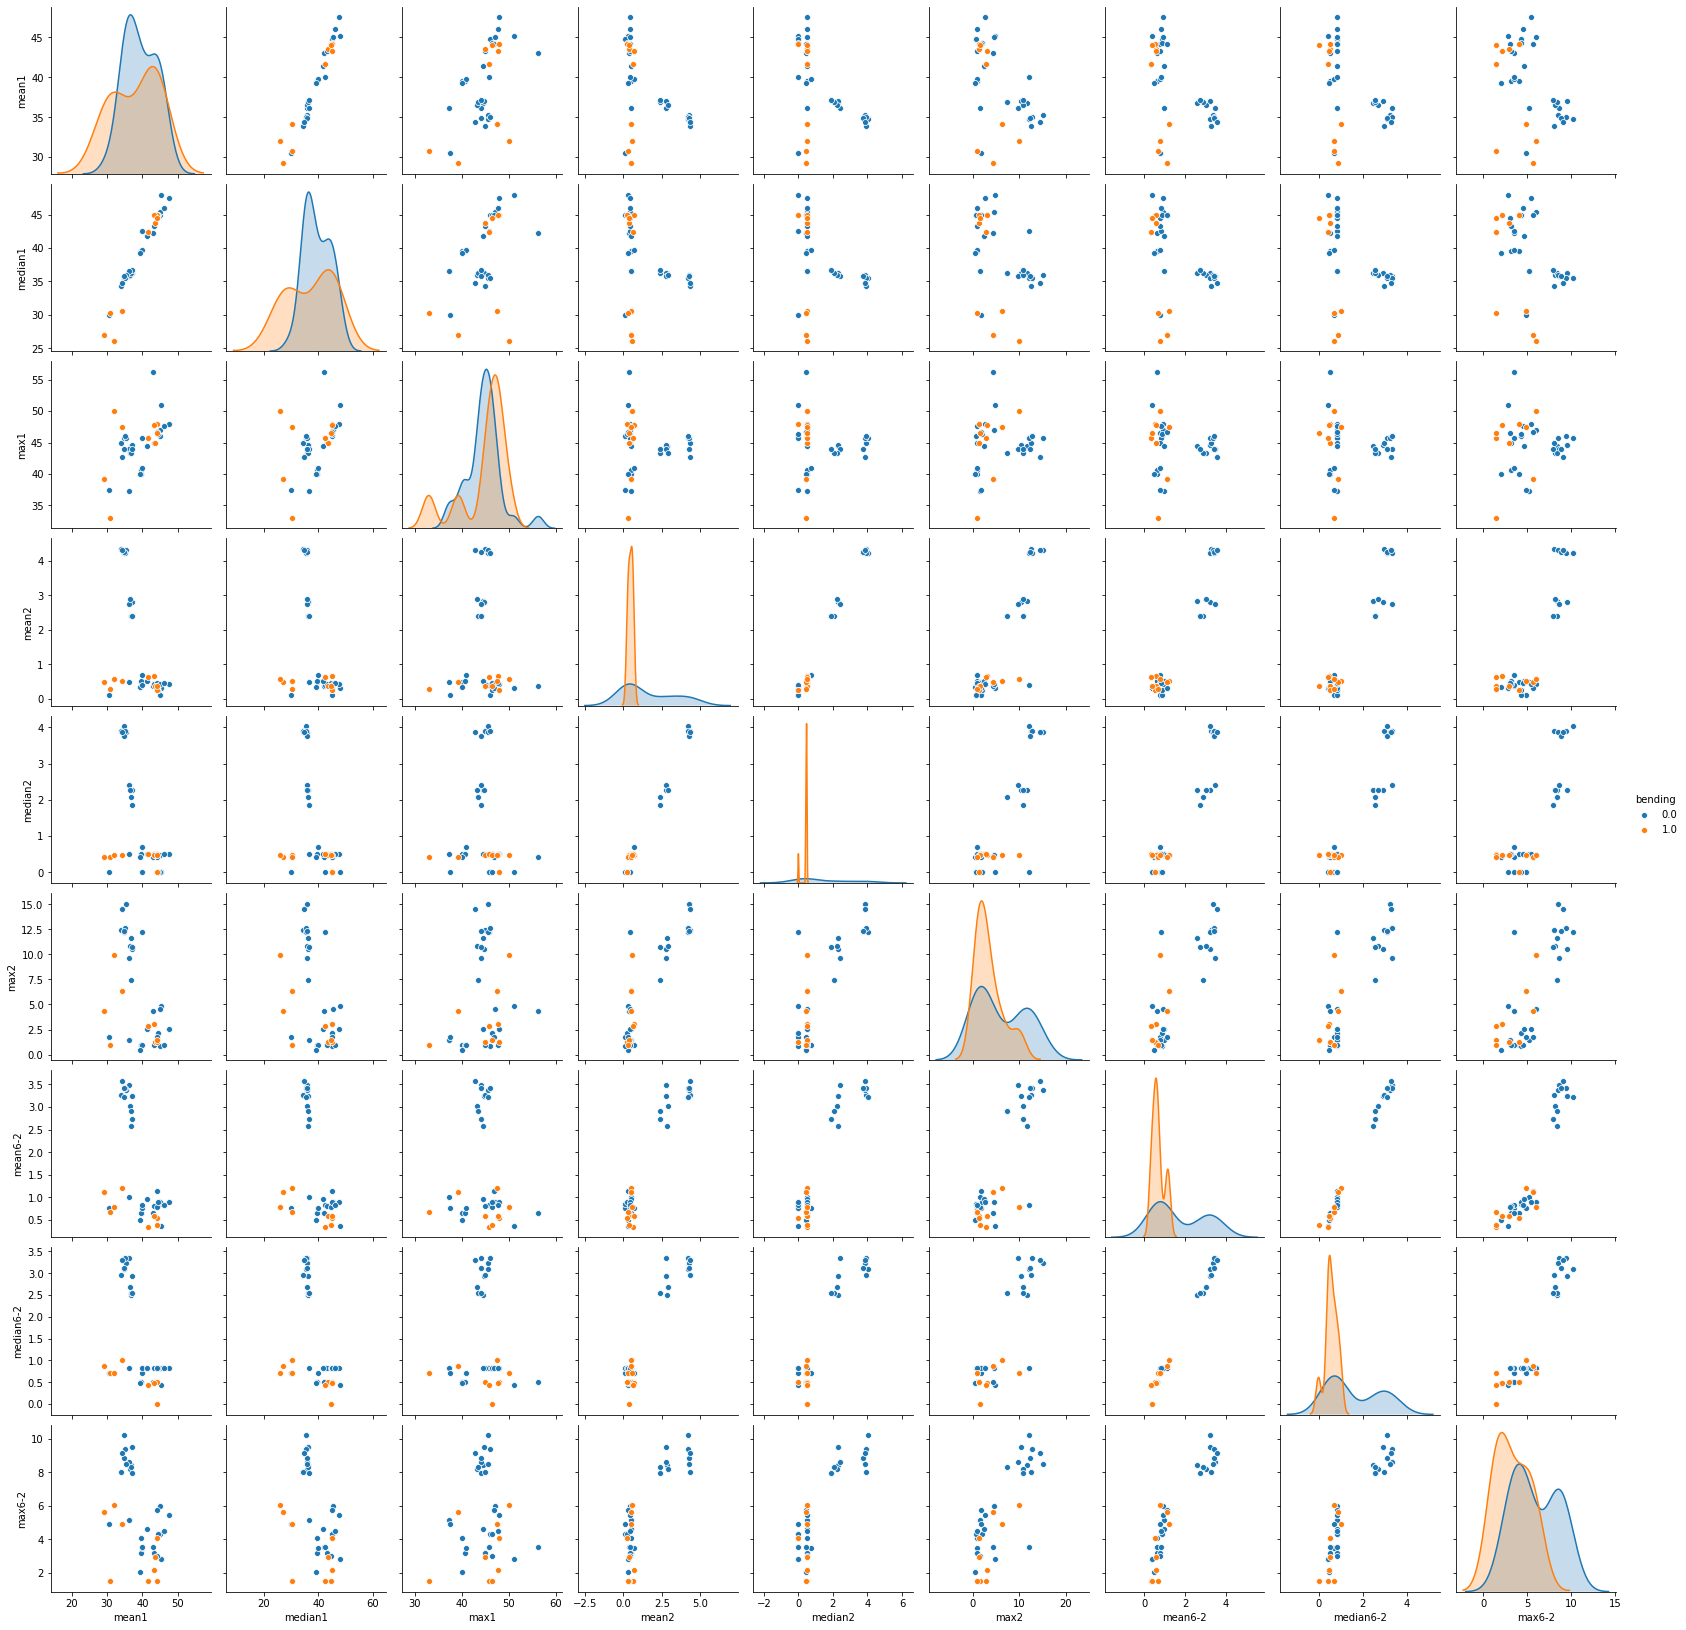

In [10]:
pairplot2 = dii[['mean1', 'median1', 'max1', 'mean2','median2', 'max2', 'mean6-2', 'median6-2', 'max6-2', 'bending']]
pairplot(pairplot2)

### There are no significant differences between the pairplots when splitting the data into halves and keeping it altogether.


In [53]:
## MAX/MEAN/MEDIAN
## filter for max mean median

def split_l_sets(l, all_files):
#     columns = ['min', 'max','mean','median','std','1stQ','3rdQ']
    columns = ['max','mean','median']

    all_columns = []
    for i in range(1, l+1):
        for j in range(1, 7):
            for col in columns:
                all_columns.append(col+str(j)+"-"+str(i))
    all_columns.append('bending')
    td_features = pd.DataFrame(columns=all_columns)

    for file in all_files:
        new_instance={}
        df = pd.read_csv(file)
        num_rows = df.shape[0]
        for sp in range(1, l+1):
            start_index = math.floor(((sp-1)/l)*num_rows)
            end_index = math.floor((sp/l)*num_rows)
            i=1
            for column in df.columns:
                if column != 'Time' and column != 'time':
                    suffix = str(i)+"-"+str(sp)
#                     new_instance['min'+suffix] = df[column][start_index:end_index].min()
                    new_instance['max'+suffix] = df[column][start_index:end_index].max()
                    new_instance['mean'+suffix] = df[column][start_index:end_index].mean()
                    new_instance['median'+suffix] = df[column][start_index:end_index].median()
#                     new_instance['std'+suffix] = df[column][start_index:end_index].std()
#                     new_instance['1stQ'+suffix] = df[column][start_index:end_index].quantile(0.25)
#                     new_instance['3rdQ'+suffix] = df[column][start_index:end_index].quantile(0.75)
                    i=i+1
            new_instance['bending'] = int(('bending' in file))
        td_features = td_features.append(new_instance,ignore_index=True)
    return td_features


In [12]:
def logistic_regression(L, files):
    td_features = split_l_sets(L, files)
    y = td_features['bending']
    td_features = td_features.drop(columns=['bending'])
    model = LogisticRegression(C=math.inf, max_iter=100, n_jobs=-1)
    rfecv = RFECV(estimator=model, cv=StratifiedKFold(5))
    rfecv = rfecv.fit( td_features, y )
    return {'feature_vector': rfecv.support_, 'feature_num': sum(rfecv.support_), 'max_cv':max(rfecv.grid_scores_)}


In [13]:
results={}
for l in range(1, 21):
    results[l]=logistic_regression(l, train_files)
print(results)  

# #keep a list of scores
# #model.grid_scores_[model.n_features_ - 1]


{1: {'feature_vector': array([ True, False, False, False, False, False, False, False,  True,
       False, False, False,  True,  True,  True, False, False, False]), 'feature_num': 5, 'max_cv': 0.925}, 2: {'feature_vector': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False]), 'feature_num': 1, 'max_cv': 0.9}, 3: {'feature_vector': array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False]), 'feature_num': 1,

In [14]:
max_cv = 0
best_l = None
for key in results:
    if results[key]['max_cv'] > max_cv:
        max_cv = results[key]['max_cv']
        best_l = key
print(results[best_l])
print(best_l)

{'feature_vector': array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
 

### (d) iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. 
### (TODO) Report the parameters of our logistic regression βi’s as well as the p-values associated with them

In [163]:
## https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
        return self.model.coef_[0], self.p_values

In [167]:

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

td_features = split_l_sets(best_l, train_files)
y = td_features['bending']
td_features = td_features.drop(columns=['bending'])
model = LogisticRegression(C=math.inf, max_iter=100, n_jobs=-1)
rfecv = RFECV(estimator=model, cv=StratifiedKFold(5))
rfecv = rfecv.fit( td_features, y )
coefs, p_values = LogisticReg().fit(td_features, y)

predictions = rfecv.predict(td_features)
predictions_prob = list(map(lambda x: x[1], rfecv.predict_proba(td_features)))
fpr, tpr, thresholds = roc_curve(predictions, predictions_prob)

p_val_coef = []
for i in range(0, len(coefs)):
    p_val_coef.append([coefs[i], p_values[i]])

df = pd.DataFrame()
df['coefficients'] = coefs
df['p-values'] = p_values
print(df)
# coef pd.DataFrame(coef)
# print(p_val_coef)
                       


     coefficients  p-values
0        0.004698       NaN
1       -0.002165       NaN
2       -0.003481       1.0
3       -0.007702       1.0
4       -0.003206       1.0
5       -0.002862       NaN
6        0.004703       1.0
7       -0.019676       1.0
8       -0.030529       NaN
9        0.012142       NaN
10       0.000793       NaN
11       0.000066       NaN
12       0.093238       1.0
13       0.052638       NaN
14       0.047145       NaN
15      -0.001583       1.0
16      -0.004686       NaN
17      -0.003856       NaN
18      -0.006103       NaN
19      -0.002194       NaN
20      -0.003231       1.0
21      -0.018571       NaN
22      -0.003507       1.0
23      -0.001989       1.0
24       0.034091       NaN
25      -0.014316       1.0
26      -0.019038       1.0
27       0.023072       1.0
28       0.000492       1.0
29      -0.005504       NaN
..            ...       ...
204     -0.034237       1.0
205     -0.028510       NaN
206     -0.036505       1.0
207     -0.012901   

/Users/smedlang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/smedlang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Confusion Matrix
[[30  0]
 [ 0  9]]


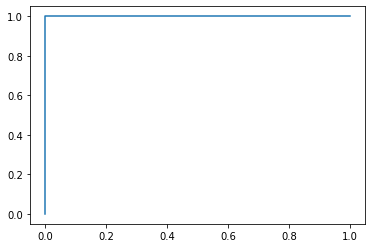

AUC = 1.0


In [16]:
conf_mtx = confusion_matrix(y,predictions)
print("Confusion Matrix")
print(conf_mtx)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print("AUC = " + str(auc(fpr, tpr)))


### (d) v. Test the classifier on the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously

In [17]:
## Predict Test data from model with best L value

td_features = split_l_sets(best_l, train_files)
y = td_features['bending']
td_features = td_features.drop(columns=['bending'])
model = LogisticRegression(C=math.inf, max_iter=100, n_jobs=-1)
rfecv = RFECV(estimator=model, cv=StratifiedKFold(5))
rfecv = rfecv.fit( td_features, y )

test_data = split_l_sets(best_l, test_files)
test_y = test_data['bending']
test_data = test_data.drop(columns=['bending'])
predictions = rfecv.predict(test_data)
# predictions_prob = rfecv.predict_proba(test_data).


### (d) vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?
Yes

### (d) vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model

In [140]:
predictions_prob = list(map(lambda x: x[1], rfecv.predict_proba(test_data)))
fpr, tpr, thresholds = roc_curve(predictions, predictions_prob)
conf_mtx = confusion_matrix(test_y,predictions)
print("Confusion Matrix")
print(conf_mtx)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.legend()
plt.show()
print("AUC = " + str(auc(fpr, tpr)))

ValueError: X has a different shape than during fitting.

### (e) Using L1-penalized logistic regression

In [62]:
##e LogisticRegressionCV Penalty="l1" solver="linear" cv="stratifiedkfold5" random_state="" f1_score, model.score, model.C_ optimal C value
from sklearn.linear_model import LogisticRegressionCV

def lasso_reg(L, files):
    train_data = split_l_sets(L, files)
    y=train_data['bending']
    X = train_data.drop(columns=['bending'])
    lasso_model = LogisticRegressionCV(penalty='l1', solver="liblinear", cv=StratifiedKFold(5), n_jobs=-1)
    lasso_model = lasso_model.fit(X, y)
    return { 'max_cv':max(lasso_model.scores_)}    


In [63]:
lasso_results = {}
for l in range(1, 21):
    lasso_results[l] = lasso_reg(l, train_files)
    

In [64]:
lasso_max_cv = 0
lasso_best_l = None
for key in lasso_results:
    if lasso_results[key]['max_cv'] > lasso_max_cv:
        lasso_max_cv = lasso_results[key]['max_cv']
        lasso_best_l = key
print(lasso_results)


{1: {'max_cv': 1.0}, 2: {'max_cv': 1.0}, 3: {'max_cv': 1.0}, 4: {'max_cv': 1.0}, 5: {'max_cv': 1.0}, 6: {'max_cv': 1.0}, 7: {'max_cv': 1.0}, 8: {'max_cv': 1.0}, 9: {'max_cv': 1.0}, 10: {'max_cv': 1.0}, 11: {'max_cv': 1.0}, 12: {'max_cv': 1.0}, 13: {'max_cv': 1.0}, 14: {'max_cv': 1.0}, 15: {'max_cv': 1.0}, 16: {'max_cv': 1.0}, 17: {'max_cv': 1.0}, 18: {'max_cv': 1.0}, 19: {'max_cv': 1.0}, 20: {'max_cv': 1.0}}


### The accuracy scores for the lasso regularization are 1.0 for each L value used. This performs better than the variable selection using p-values, and takes much less time to execute.  

In [ ]:
# best_l_data = split_l_sets(best_l, train_files)
# y = best_l_data['bending']
# best_l_data = best_l_data.drop(columns=['bending'])
# lasso_reg(best_l_data, y)


### (f) Multi-class Classification (The Realistic Case)


In [100]:
def split_l_sets_multiclass(l, all_files):
#     columns = ['min', 'max','mean','median','std','1stQ','3rdQ']
    columns = ['max','mean','median']

    all_columns = []
    for i in range(1, l+1):
        for j in range(1, 7):
            for col in columns:
                all_columns.append(col+str(j)+"-"+str(i))
    all_columns.append('bending')
    td_features = pd.DataFrame(columns=all_columns)

    for file in all_files:
        new_instance={}
        df = pd.read_csv(file)
        num_rows = df.shape[0]
        for sp in range(1, l+1):
            start_index = math.floor(((sp-1)/l)*num_rows)
            end_index = math.floor((sp/l)*num_rows)
            i=1
            for column in df.columns:
                if column != 'Time' and column != 'time':
                    suffix = str(i)+"-"+str(sp)
#                     new_instance['min'+suffix] = df[column][start_index:end_index].min()
                    new_instance['max'+suffix] = df[column][start_index:end_index].max()
                    new_instance['mean'+suffix] = df[column][start_index:end_index].mean()
                    new_instance['median'+suffix] = df[column][start_index:end_index].median()
#                     new_instance['std'+suffix] = df[column][start_index:end_index].std()
#                     new_instance['1stQ'+suffix] = df[column][start_index:end_index].quantile(0.25)
#                     new_instance['3rdQ'+suffix] = df[column][start_index:end_index].quantile(0.75)
                    i=i+1
            new_instance['bending'] = int(('bending' in file))
            if 'sitting' in file:
                new_instance['folder'] = 'sitting'
            if 'walking' in file:
                new_instance['folder'] = 'walking'
            if 'cycling' in file:
                new_instance['folder'] = 'cycling'
            if 'lying' in file:
                new_instance['folder'] = 'lying'
            if 'standing' in file:
                new_instance['folder'] = 'standing'
            if 'bending' in file:
                new_instance['folder'] = 'bending'
        td_features = td_features.append(new_instance,ignore_index=True)
    return td_features


In [156]:
# f solver="saga" cross validation = 4, multi_class="multinomial" need to standardize 
from sklearn.preprocessing import MinMaxScaler

def multiclass_reg(L, files):
    scaler = MinMaxScaler()
    train_data = split_l_sets_multiclass(L, files)
    test_data = split_l_sets_multiclass(L, test_files)
    y_test = test_data['bending']
    X_test = test_data.drop(columns=['folder', 'bending'])
    X = train_data.drop(columns=['folder', 'bending'])
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    y=train_data['folder']
    multiclass = LogisticRegressionCV(penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000)
    multiclass = multiclass.fit(X,y)
    
    return {'max_cv':(multiclass.score(X, y))}



In [157]:
multi_results = {}
for l in range(1, 21):
    multi_results[l] = multiclass_reg(l, train_files)
    


In [ ]:
print(multi_results)


In [128]:
multi_max_cv = 0
multi_best_l = None
for key in multi_results:
    if multi_results[key]['max_cv'] > multi_max_cv:
        multi_max_cv = multi_results[key]['max_cv']
        multi_best_l = key
print("Best L = " + str(multi_best_l))





Best L = 1
Confusion Matrix


bending  cycling  lying  sitting  standing  walking
bending         3        0      0        1         0        0
cycling         0        9      0        0         0        0
lying           0        0      9        0         0        0
sitting         2        0      2        3         2        0
standing        0        0      2        2         5        0
walking         0        0      0        0         0        9

### (f) i ROC Curve, Confusion Matrix 

Test Error = 0.22448979591836735
Confusion Matrix
          bending  cycling  lying  sitting  standing  walking
bending         3        0      0        1         0        0
cycling         0        9      0        0         0        0
lying           0        0      9        0         0        0
sitting         2        0      2        3         2        0
standing        0        0      2        2         5        0
walking         0        0      0        0         0        9


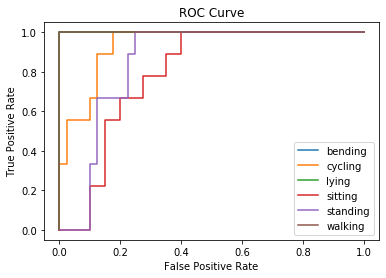

In [143]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

scaler = MinMaxScaler()
train_data = split_l_sets_multiclass(multi_best_l, train_files)
test_data = split_l_sets_multiclass(multi_best_l, test_files)
X = train_data.drop(columns=['bending', 'folder'])
y = train_data['folder']
scaler = scaler.fit(X)
X = scaler.transform(X)
y_test = test_data['folder']
X_test = test_data.drop(columns=['folder', 'bending'])
scaler = MinMaxScaler().fit(X_test)
X_test = scaler.transform(X_test)
multiclass = LogisticRegressionCV(penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000)
multiclass = multiclass.fit(X,y)
multi_predictions = multiclass.predict(X_test)
# print(multi_predictions)
multi_predictions_prob = list(map(lambda x: x[1], multiclass.predict_proba(X_test)))

## Calculate Test Error
miscalc=0
for i in range(0, len(multi_predictions)):
    if multi_predictions[i] != y_test[i]:
        miscalc += 1
print("Test Error = " + str(miscalc/len(multi_predictions)))

m_conf_mtx = confusion_matrix(y_test,multi_predictions)
folders=['bending', 'cycling', 'lying', 'sitting', 'standing', 'walking']

# print("AUC:" + str(auc))
print("Confusion Matrix")
# print(m_conf_mtx)
m_conf_mtx = pd.DataFrame(m_conf_mtx, columns=folders, index=folders)
print(m_conf_mtx)
fpr = {}
tpr = {}
roc_auc = {}
pred = multiclass.decision_function(X_test)
for i in range(len(folders)):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=folders)[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(folders)):
    plt.plot(fpr[i], tpr[i], label=folders[i])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()
plt.show()

### (f) ii Repeat 1(f)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

In [151]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

def gaussian(L, files):
    train_data = split_l_sets_multiclass(L, files)
    X = train_data.drop(columns=['folder', 'bending'])
    y=train_data['folder']
    gauss = GaussianNB()
    gauss = gauss.fit(X,y)
    return {'max_cv':(gauss.score(X, y))}

def multinomial_nb(L, files):
    train_data = split_l_sets_multiclass(L, files)
    X = train_data.drop(columns=['folder', 'bending'])
    y=train_data['folder']
    mnb = MultinomialNB()
    mnb = mnb.fit(X,y)
    return {'max_cv':(mnb.score(X, y))}


In [152]:

g_results={}
mnb_results = {}
for l in range(1, 21):
    g_results[l] = gaussian(l, train_files)
    mnb_results[l] = multinomial_nb(l, train_files)



In [162]:
print(g_results)
g_max_cv = 0
g_best_l = None
for key in g_results:
    if g_results[key]['max_cv'] > g_max_cv:
        g_max_cv = g_results[key]['max_cv']
        g_best_l = key
print(mnb_results)
mnb_max_cv = 0
mnb_best_l = None
for key in g_results:
    if mnb_results[key]['max_cv'] > mnb_max_cv:
        mnb_max_cv = mnb_results[key]['max_cv']
        mnb_best_l = key
print("Gaussian Best L = " + str(g_best_l))

print("Multinomial NB Best L = " + str(mnb_best_l))

gnb_X_train = split_l_sets_multiclass(g_best_l, train_files)
y_train = gnb_X_train['folder']
X_train = gnb_X_train.drop(columns=['folder', 'bending'])
gnb = GaussianNB().fit(X_train, y_train)

gnb_X_test = split_l_sets_multiclass(g_best_l, train_files)
y_test = gnb_X_test['folder']
X_test = gnb_X_test.drop(columns=['folder', 'bending'])
gnb_predictions = gnb.predict(X_test)

gnb_error = 0
for i in range(0, len(gnb_predictions)):
    if gnb_predictions[i] != y_test[i]:
        gnb_error += 1

print("Gaussian NB Test Error:" + str(gnb_error/len(gnb_predictions)))
                           

mnb_X_train = split_l_sets_multiclass(mnb_best_l, train_files)
y_train = mnb_X_train['folder']
X_train = mnb_X_train.drop(columns=['bending', 'folder'])
mnb = MultinomialNB().fit(X_train, y_train)
mnb_X_test = split_l_sets_multiclass(mnb_best_l, test_files)
y_test = mnb_X_test['folder']
X_test = mnb_X_test.drop(columns=['bending', 'folder'])
mnb_predictions = mnb.predict(X_test)

mnb_error = 0
for i in range(0, len(mnb_predictions)):
    if mnb_predictions[i] != y_test[i]:
        mnb_error += 1

print("Multinomial NB Test Error:" + str(mnb_error/len(mnb_predictions)))




{1: {'max_cv': 1.0}, 2: {'max_cv': 1.0}, 3: {'max_cv': 1.0}, 4: {'max_cv': 1.0}, 5: {'max_cv': 1.0}, 6: {'max_cv': 1.0}, 7: {'max_cv': 1.0}, 8: {'max_cv': 1.0}, 9: {'max_cv': 1.0}, 10: {'max_cv': 1.0}, 11: {'max_cv': 1.0}, 12: {'max_cv': 1.0}, 13: {'max_cv': 1.0}, 14: {'max_cv': 1.0}, 15: {'max_cv': 1.0}, 16: {'max_cv': 1.0}, 17: {'max_cv': 1.0}, 18: {'max_cv': 1.0}, 19: {'max_cv': 1.0}, 20: {'max_cv': 1.0}}
Gaussian Best L = 1
{1: {'max_cv': 0.9230769230769231}, 2: {'max_cv': 0.9487179487179487}, 3: {'max_cv': 0.9487179487179487}, 4: {'max_cv': 0.9743589743589743}, 5: {'max_cv': 0.9743589743589743}, 6: {'max_cv': 0.9743589743589743}, 7: {'max_cv': 0.9743589743589743}, 8: {'max_cv': 0.9743589743589743}, 9: {'max_cv': 0.9743589743589743}, 10: {'max_cv': 0.9743589743589743}, 11: {'max_cv': 0.9743589743589743}, 12: {'max_cv': 1.0}, 13: {'max_cv': 0.9743589743589743}, 14: {'max_cv': 1.0}, 15: {'max_cv': 0.9743589743589743}, 16: {'max_cv': 0.9743589743589743}, 17: {'max_cv': 0.9743589743589

### (f) iii Which method is better for multi-class classification in this problem?
Gaussian is a better method for multi-class classification as shown by having 0 Test Error

### 2. ISLR 3.7.4

a) We cannot be sure but we can expect the linear regression to have a smaller RSS because the relationship between X and Y is linear

b) We can expect the cubic regression to have a larger Rss again because it's likely to be overfit, but it's not possible to know for sure without knowing the test data

c) The cubic regression will be better fit to the train data and therefore have a smaller train RSS

d) It's not possible to know because we don't know the nature of the data and how non-linear it is. If it is more lienar than cubic, then the linear regression will have a lower RSS, and if it is closer to cubic nature, the cubic regression will have a lower RSS.

### 3. ISLR, 4.7.3
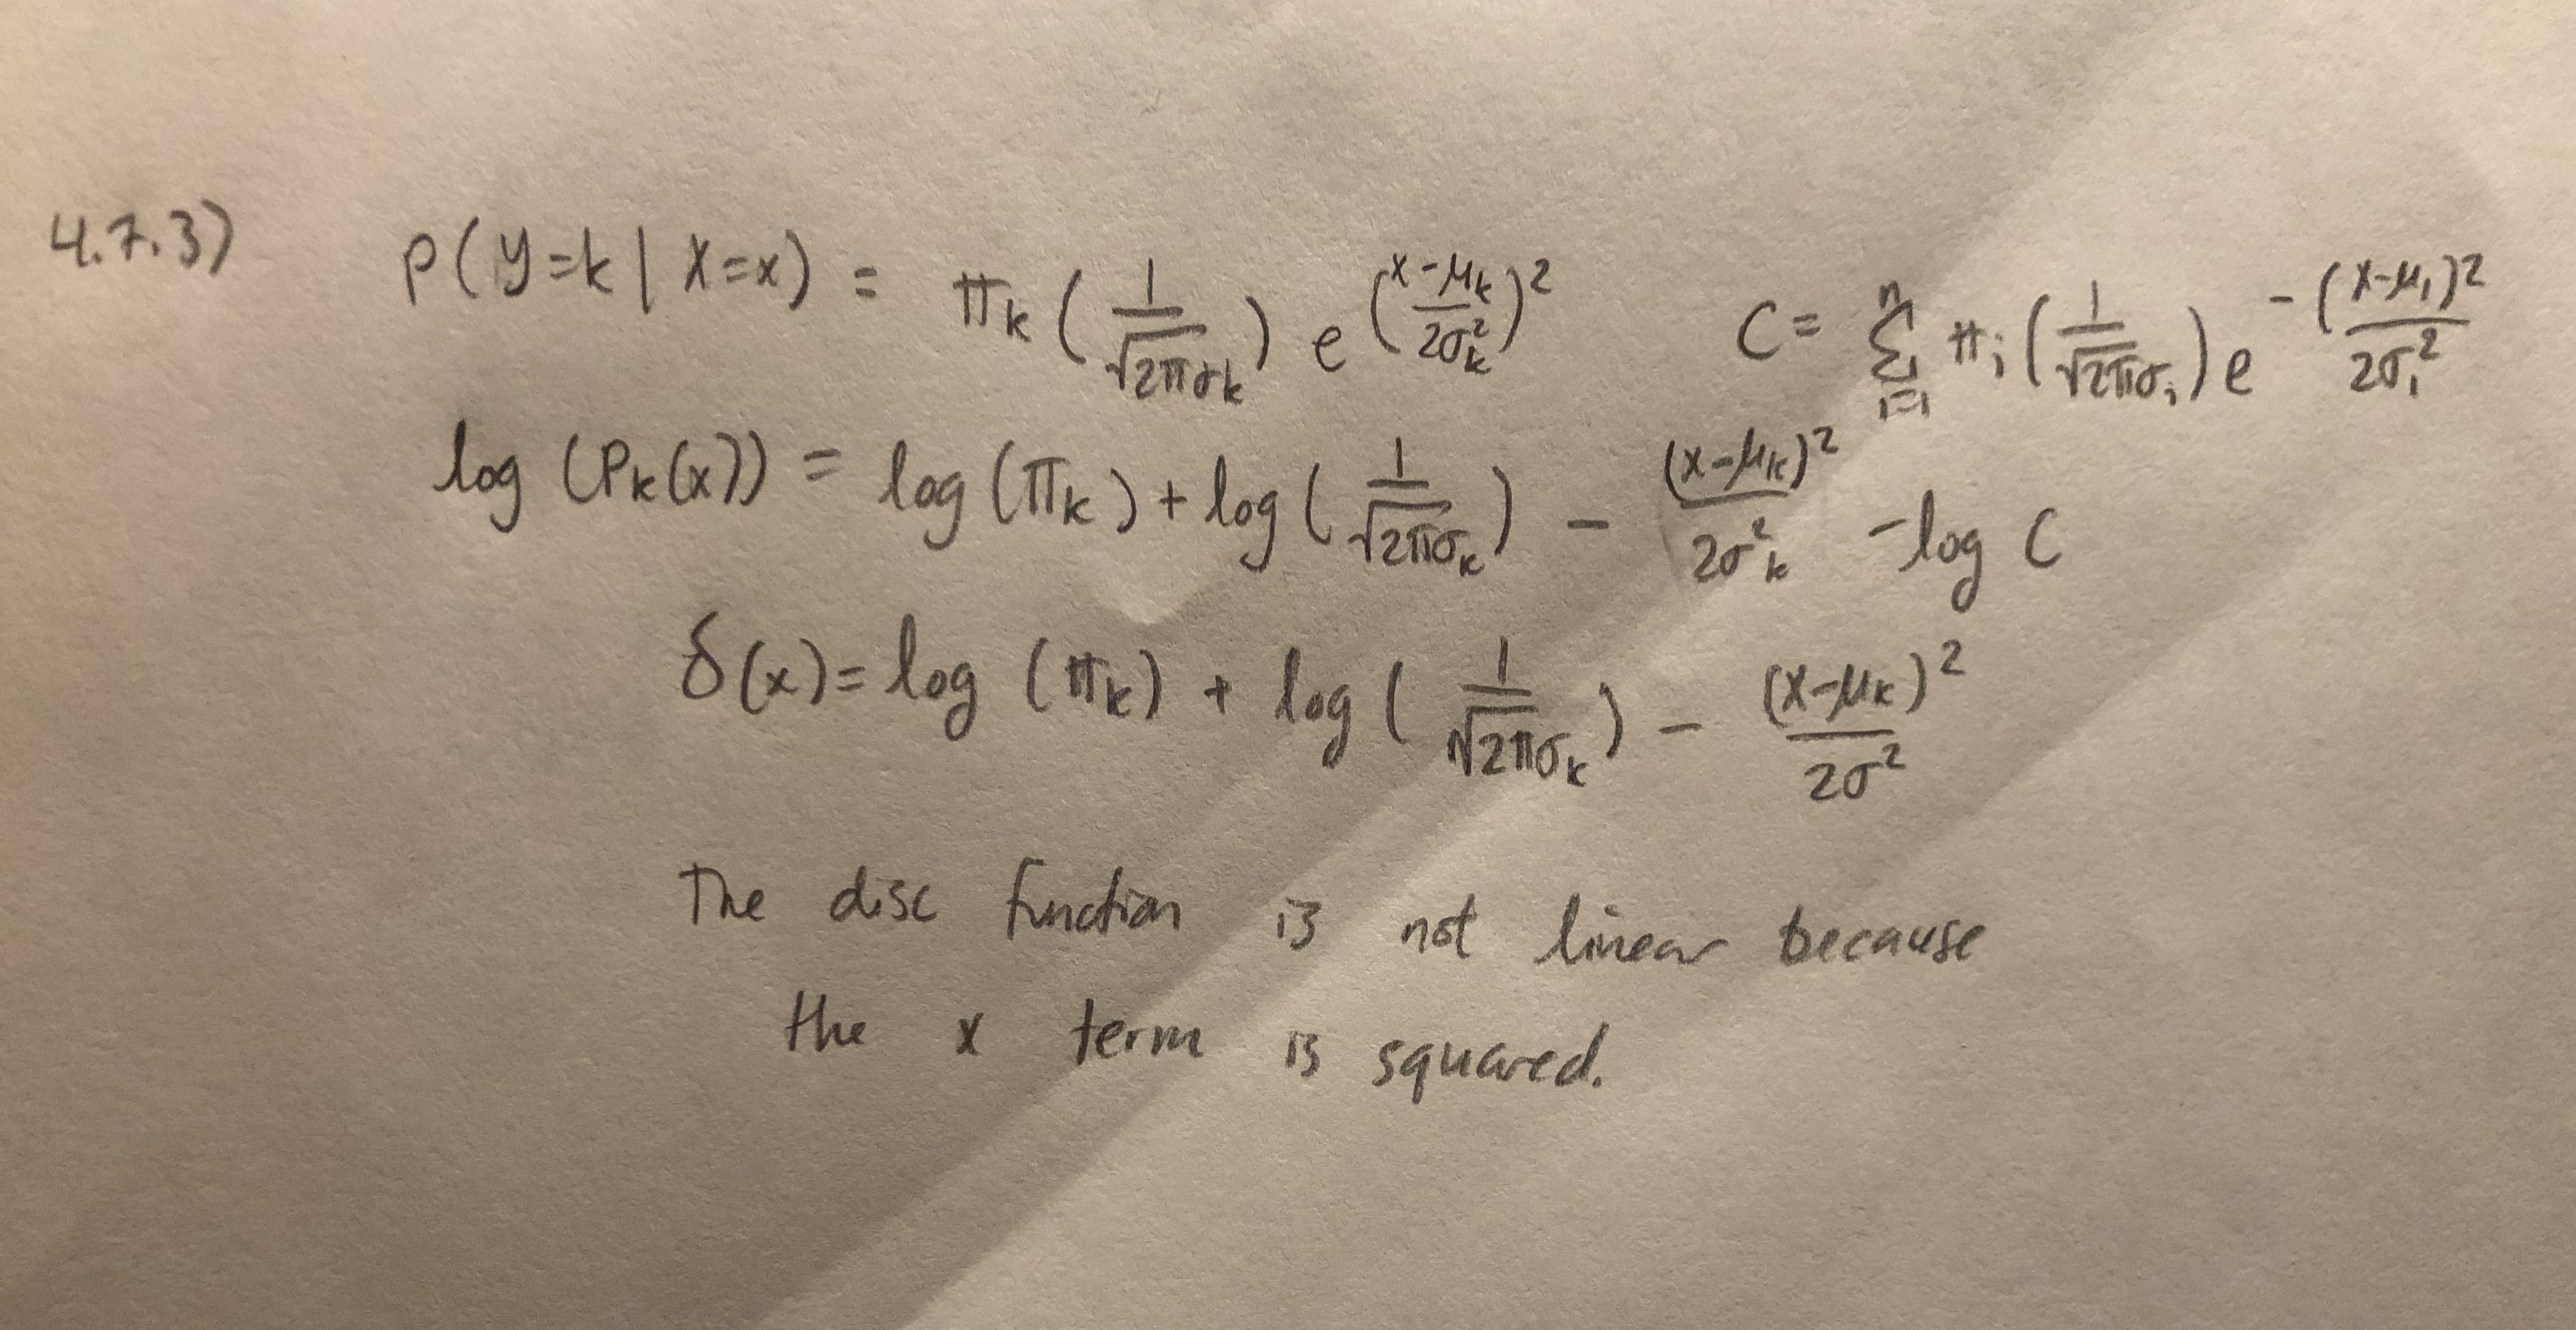

### 4. ISLR 4.7.7
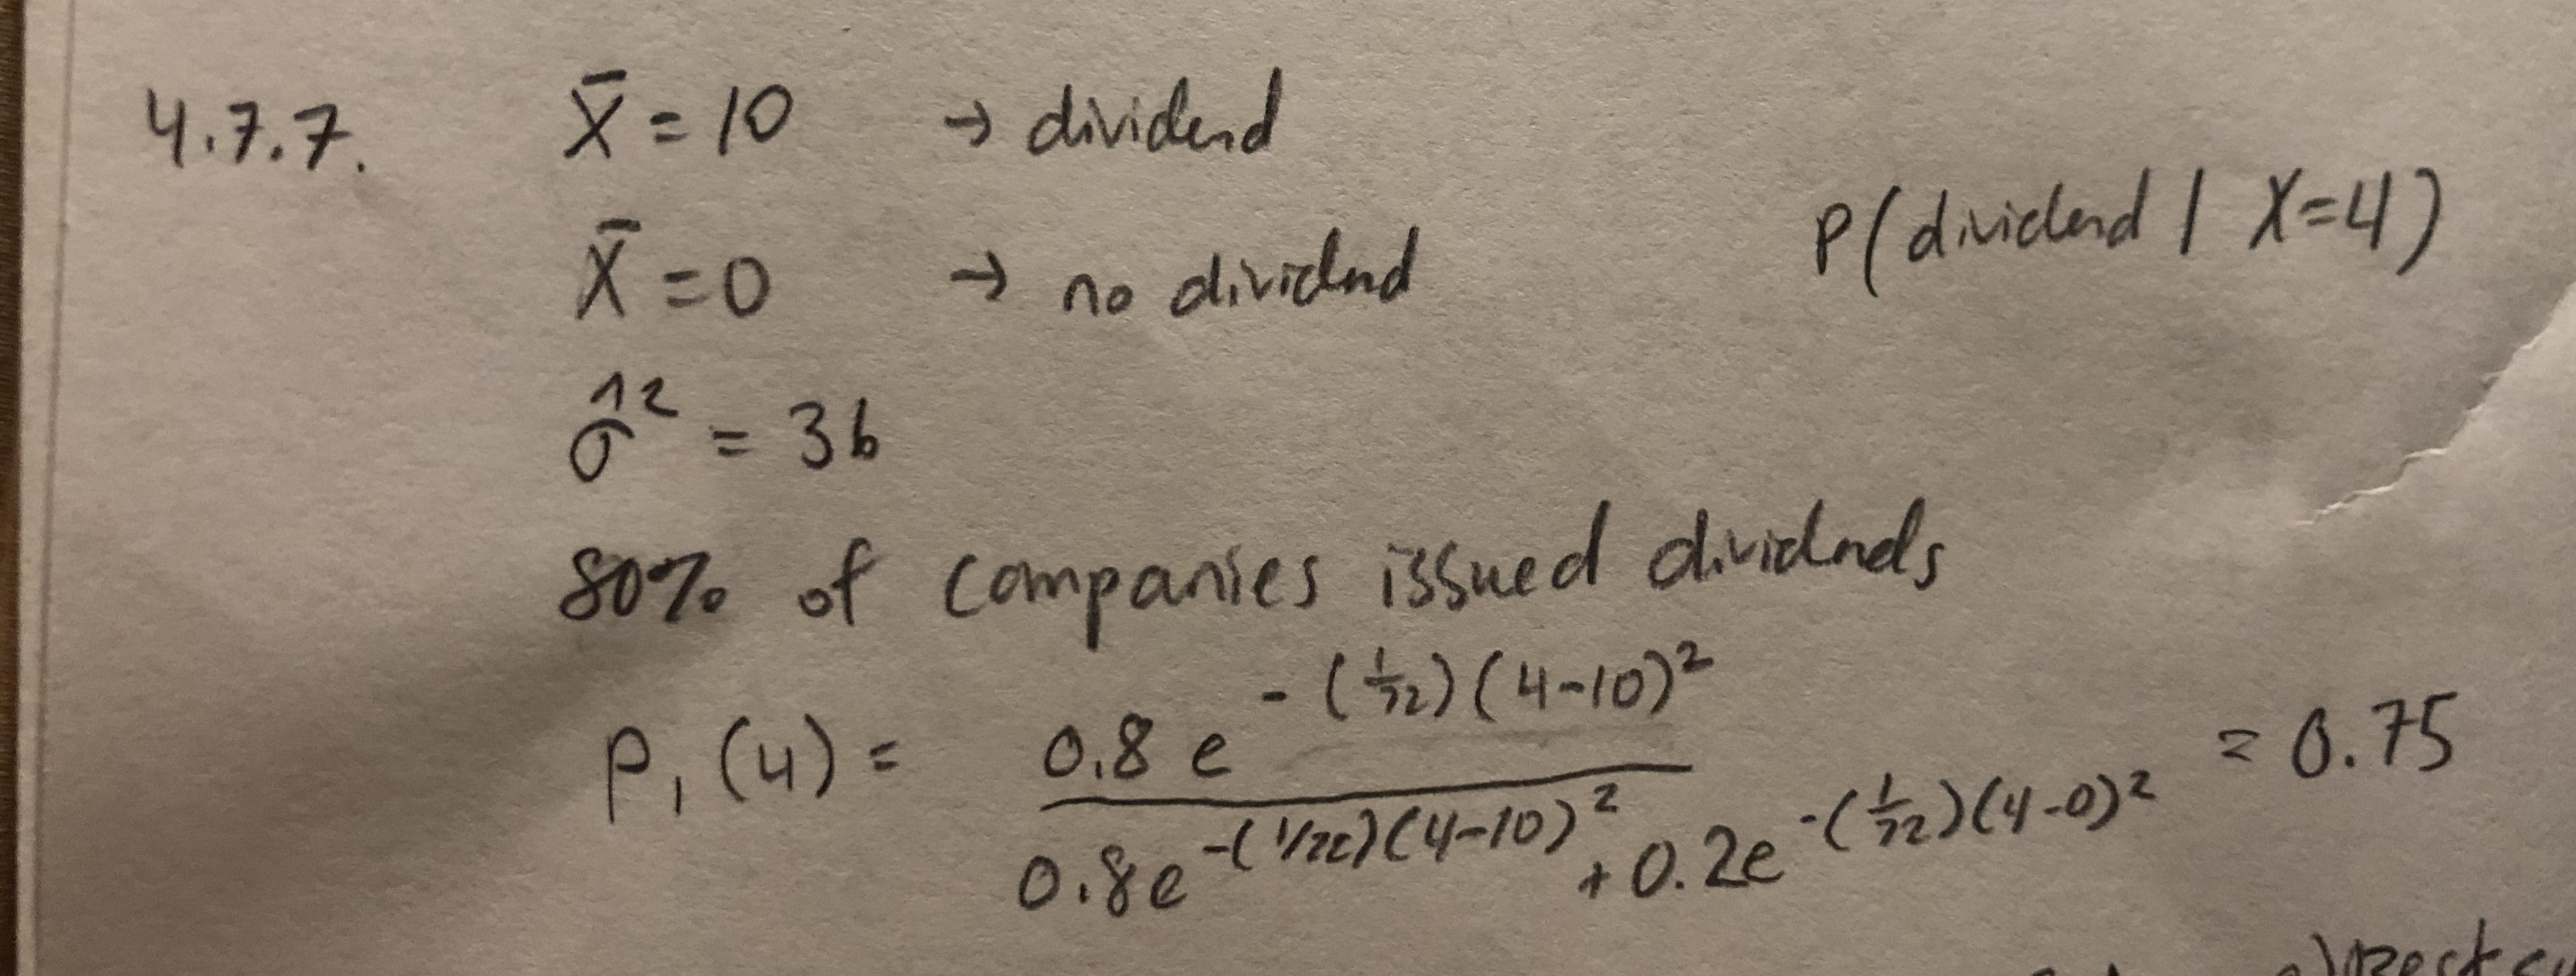
